In [1]:
import functions as fx
import log_reg_functions as lrf
import loaddata as ld
import NeuralNetwork as nn

import numpy as np
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.neural_network import MLPRegressor

# D
Creating the Franke function with noise.

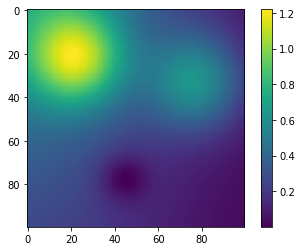

In [2]:
n=100
x = np.linspace(0,1,n)
y = x
x_mesh, y_mesh  = np.meshgrid(x,y)
noise_level     = 0.0
frank           = fx.FrankeFunction(x_mesh, y_mesh, noise_level)

plt.imshow(frank)
plt.colorbar()
plt.show()

frank=frank.ravel()
frank=frank.reshape([len(frank),1])
design=fx.DesignDesign(x,y,8)


In [6]:
epochs=1000
batch_size=int(len(frank)/20)
n_features=design.shape[1]
etavec = np.logspace(-6, -1, 6)
lmbvec = np.logspace(-6, -1, 6)
lmbvec[0]=0
k=5
activation = [lrf.sigmoid, lrf.sigmoid, lrf.relu]
derivative = [lrf.sigmoid_deriv, lrf.sigmoid_deriv, lrf.relu_deriv]



y_folds, x_folds = lrf.k_fold_reshaper(k,frank,design,shuffle=True)
test_loss = np.zeros((len(etavec), len(lmbvec)))
test_r2 = np.zeros((len(etavec), len(lmbvec)))
for i, etas in enumerate(etavec):
    for j, lmb in enumerate(lmbvec):
        
        for kf in range(k):
            xtrain = x_folds[np.arange(len(x_folds))!=kf]      # Featch all but the i-th element
            xtrain = np.concatenate(xtrain,axis=0)
            ytrain = y_folds[np.arange(len(y_folds))!=kf]
            ytrain = np.concatenate(ytrain,axis=0)
            xtest  = x_folds[kf]
            ytest  = y_folds[kf]
            
            np.random.seed(2019)
            neural_net = nn.ANN(lmb=lmb, bias=0, eta=etas,early_stop_tol = 10e-01,\
                                early_stop_nochange=200, mode = 'regression', regularization = 'l1')            
            neural_net.add_layers(n_features=[n_features,50,20], n_neurons = [50,20,1] , n_layers=3)

            neural_net.train(epochs, batch_size, xtrain,ytrain,activation,derivative \
                             ,xtest,ytest, verbose=False)

            pred = neural_net.feed_out(xtest, activation)
            test_loss[i,j] +=  fx.MSE(pred.ravel(),ytest.T)
            test_r2[i,j] +=  fx.R2Score(pred.ravel(),ytest.T)
            
        print('test loss for', '\u03B7 =', etas, '&', '\u03BB =', lmb, '=', test_loss [i,j]/k)

test_loss = test_loss/k
test_r2 = test_r2/k

test loss for η = 1e-06 & λ = 0.0 = 0.471925377544027
test loss for η = 1e-06 & λ = 1e-05 = 0.4719253279428723
test loss for η = 1e-06 & λ = 0.0001 = 0.47192488153288875
test loss for η = 1e-06 & λ = 0.001 = 0.4719204174751572
test loss for η = 1e-06 & λ = 0.01 = 0.4718757811108292
test loss for η = 1e-06 & λ = 0.1 = 0.47142982323741867
test loss for η = 1e-05 & λ = 0.0 = 0.45181962205433857
test loss for η = 1e-05 & λ = 1e-05 = 0.45181918260456894
test loss for η = 1e-05 & λ = 0.0001 = 0.4518152275902267
test loss for η = 1e-05 & λ = 0.001 = 0.45177568077288643
test loss for η = 1e-05 & λ = 0.01 = 0.45138053782204157
test loss for η = 1e-05 & λ = 0.1 = 0.4474609369510727
test loss for η = 0.0001 & λ = 0.0 = 0.3241848444987132
test loss for η = 0.0001 & λ = 1e-05 = 0.32418269093827373
test loss for η = 0.0001 & λ = 0.0001 = 0.3241633096906552
test loss for η = 0.0001 & λ = 0.001 = 0.32396957621464384
test loss for η = 0.0001 & λ = 0.01 = 0.3220396091580133
test loss for η = 0.0001 & λ 

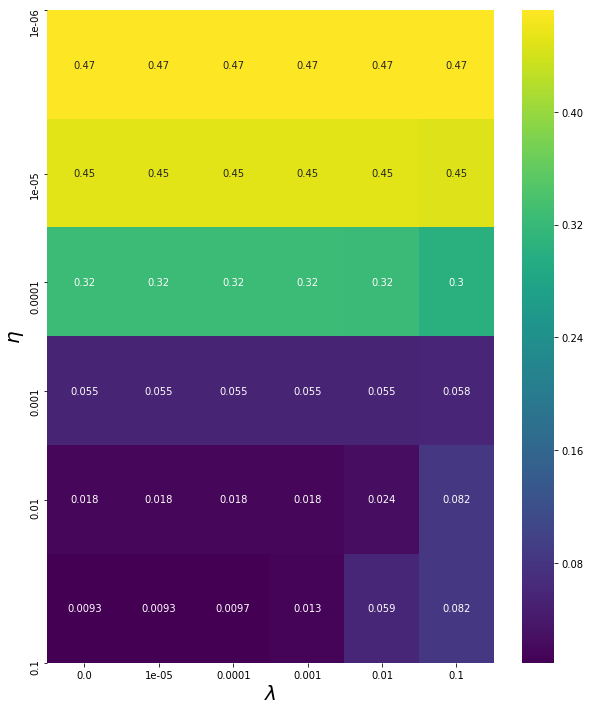

In [7]:
yticklabels = etavec
xticklabels = lmbvec
fig, ax = plt.subplots(figsize = (10, 12))
sns.heatmap(test_loss, annot=True, ax=ax, cmap="viridis",\
            yticklabels=yticklabels, xticklabels=xticklabels)
#ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$", fontsize=20)
ax.set_xlabel("$\lambda$", fontsize=20)
tmp = np.arange(len(etavec))+0.5
tmp[0] = 0
tmp[-1]+=0.5
ax.set_yticks(tmp)
tmp = np.arange(len(lmbvec)) + 0.5
ax.set_xticks(tmp)
plt.show()

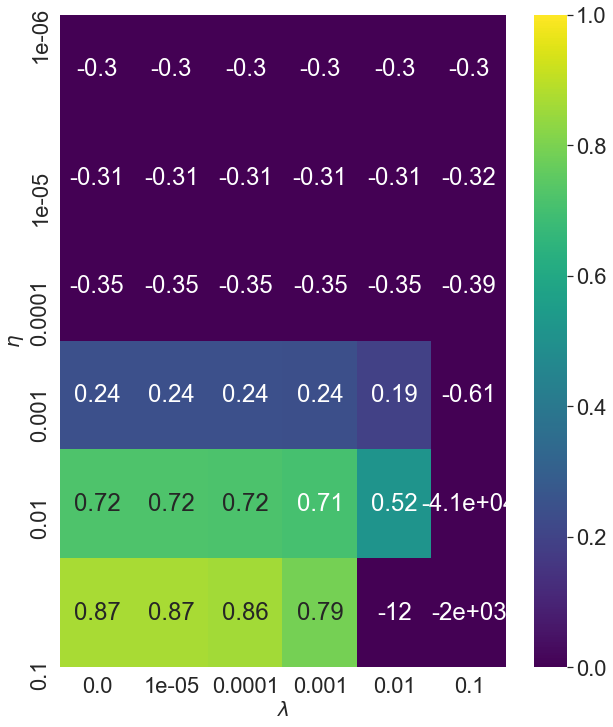

In [19]:
yticklabels = etavec
xticklabels = lmbvec
fig, ax = plt.subplots(figsize = (10, 12))
sns.heatmap(test_r2, annot=True, ax=ax, cmap="viridis",\
            yticklabels=yticklabels, xticklabels=xticklabels, vmin=0, vmax=1)
#ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$", fontsize=20)
ax.set_xlabel("$\lambda$", fontsize=20)
tmp = np.arange(len(etavec))+0.5
tmp[0] = 0
tmp[-1]+=0.5
ax.set_yticks(tmp)
tmp = np.arange(len(lmbvec)) + 0.5
ax.set_xticks(tmp)
plt.show()

In [8]:
best_eta_index, best_lmb_index = np.where(test_loss == np.min(test_loss))
best_eta,best_lmb = etavec[best_eta_index], lmbvec[best_lmb_index] 
best_lmb = 0
print('eta=',best_eta)
print('lmb=',best_lmb)

eta= [0.1]
lmb= 0


In [ ]:

test_loss_best = 0
test_r2_best = 0
for kf in range(k):
            xtrain = x_folds[np.arange(len(x_folds))!=kf]      # Featch all but the i-th element
            xtrain = np.concatenate(xtrain,axis=0)
            ytrain = y_folds[np.arange(len(y_folds))!=kf]
            ytrain = np.concatenate(ytrain,axis=0)
            xtest  = x_folds[kf]
            ytest  = y_folds[kf]
            
            np.random.seed(2019)
            neural_net = nn.ANN(lmb=best_lmb, bias=0, eta=best_eta,early_stop_tol = 10e-05,\
                                early_stop_nochange=200, mode = 'regression', regularization = 'l1')            
            neural_net.add_layers(n_features=[n_features,50,20], n_neurons = [50,20,1] , n_layers=3)

            neural_net.train(epochs, batch_size, xtrain,ytrain,activation,derivative \
                             ,xtest,ytest, verbose=True)

            pred = neural_net.feed_out(xtest, activation)
            test_loss_best +=  fx.MSE(pred.ravel(),ytest.T)
            test_r2_best +=  fx.R2Score(pred.ravel(),ytest.T)

test_loss_best /= k
test_r2_best /= k
cost_test, cost_train = neural_net.costs()
print(test_r2_best, 'r2 score')
print(test_loss_best, 'MSE')
            

Epoch 1 loss 0.05271255473005172
Epoch 2 loss 0.04007925589632979
Epoch 3 loss 0.03466322928456924
Epoch 4 loss 0.03369915456012022
Epoch 5 loss 0.030364637751371916
Epoch 6 loss 0.0270901221182151
Epoch 7 loss 0.024352767920148396
Epoch 8 loss 0.022602774717721864
Epoch 9 loss 0.02062654233325253
Epoch 10 loss 0.019582207726176123
Epoch 11 loss 0.01902327683685682
Epoch 12 loss 0.01814525873650022
Epoch 13 loss 0.017171556621954
Epoch 14 loss 0.017026399501856672
Epoch 15 loss 0.016501730234490045
Epoch 16 loss 0.015860849717808167
Epoch 17 loss 0.015416838494472682
Epoch 18 loss 0.014560958031356982
Epoch 19 loss 0.014850299640579948
Epoch 20 loss 0.01403395403234657
Epoch 21 loss 0.013557206624677827
Epoch 22 loss 0.013383019835819977
Epoch 23 loss 0.012934073894597999
Epoch 24 loss 0.012680322079950958
Epoch 25 loss 0.012247598331677018
Epoch 26 loss 0.012056597660107667
Epoch 27 loss 0.012011850293865613
Epoch 28 loss 0.011853077542301143
Epoch 29 loss 0.011659151825860935
Epoch 3

Epoch 233 loss 0.002963423400176499
Epoch 234 loss 0.002946794646940935
Epoch 235 loss 0.002941944381459471
Epoch 236 loss 0.002927387505094547
Epoch 237 loss 0.0029207616075655417
Epoch 238 loss 0.002909319263691039
Epoch 239 loss 0.002927334910791858
Epoch 240 loss 0.0029114311237557174
Epoch 241 loss 0.002911377132345554
Epoch 242 loss 0.0028774821673569376
Epoch 243 loss 0.0028788861145284117
Epoch 244 loss 0.0028700859996275757
Epoch 245 loss 0.0028536107631807407
Epoch 246 loss 0.002868226784320992
Epoch 247 loss 0.0028529083558497957
Epoch 248 loss 0.0028251718952274213
Epoch 249 loss 0.0028242401514103513
Epoch 250 loss 0.0028691351832515846
Epoch 251 loss 0.0027984719189187166
Epoch 252 loss 0.00280027509659354
Epoch 253 loss 0.002790612979015503
Epoch 254 loss 0.002778268832714504
Epoch 255 loss 0.002776193770557257
Epoch 256 loss 0.0027849422315325513
Epoch 257 loss 0.00278193410712985
Epoch 258 loss 0.002753424087356474
Epoch 259 loss 0.002759663462020093
Epoch 260 loss 0.0

Epoch 458 loss 0.0019033504241884375
Epoch 459 loss 0.0018918512267040537
Epoch 460 loss 0.001891138677007966
Epoch 461 loss 0.0018888719270406368
Epoch 462 loss 0.0019290725451724295
Epoch 463 loss 0.0018846937405816503
Epoch 464 loss 0.001895909625709224
Epoch 465 loss 0.0018795001897235226
Epoch 466 loss 0.0018829956569926516
Epoch 467 loss 0.0019033815439711017
Epoch 468 loss 0.001878339399734613
Epoch 469 loss 0.0018709030170152164
Epoch 470 loss 0.0018723396755010852
Epoch 471 loss 0.001878433249222145
Epoch 472 loss 0.0018637560942384899
Epoch 473 loss 0.0018662021929497714
Epoch 474 loss 0.0018686714406705583
Epoch 475 loss 0.0018587950828839364
Epoch 476 loss 0.001855167865251748
Epoch 477 loss 0.0018556138067238597
Epoch 478 loss 0.0018966856141542933
Epoch 479 loss 0.0018569010313962129
Epoch 480 loss 0.0018835218694418607
Epoch 481 loss 0.0018583327301238942
Epoch 482 loss 0.0018852315325586972
Epoch 483 loss 0.0018606614279454696
Epoch 484 loss 0.0018460561244687552
Epoch 

Epoch 681 loss 0.0015433854735670228
Epoch 682 loss 0.0015466871688447133
Epoch 683 loss 0.001563401207456209
Epoch 684 loss 0.0015557990377468517
Epoch 685 loss 0.001555897483485119
Epoch 686 loss 0.0015408919190661571
Epoch 687 loss 0.0015428740794600113
Epoch 688 loss 0.0015450578816149547
Epoch 689 loss 0.0015396336852784242
Epoch 690 loss 0.001576516089028446
Epoch 691 loss 0.0015364182791578003
Epoch 692 loss 0.0015353249308210659
Epoch 693 loss 0.0015384851514357388
Epoch 694 loss 0.0015330781226009416
Epoch 695 loss 0.0015560471448669189
Epoch 696 loss 0.0015327571726373795
Epoch 697 loss 0.0015299425006267302
Epoch 698 loss 0.001530198203203633
Epoch 699 loss 0.001528662540672717
Epoch 700 loss 0.0015243584613795816
Epoch 701 loss 0.0015394965460020168
Epoch 702 loss 0.0015278765520048343
Epoch 703 loss 0.0015440403326896167
Epoch 704 loss 0.0015275665592033765
Epoch 705 loss 0.0015193208841351154
Epoch 706 loss 0.001520453079192386
Epoch 707 loss 0.0015180823117331857
Epoch 7

Epoch 143 loss 0.004021688082081285
Epoch 144 loss 0.00402142632067255
Epoch 145 loss 0.003954858294236592
Epoch 146 loss 0.003954843845582992
Epoch 147 loss 0.003924670797742286
Epoch 148 loss 0.0039266082358528805
Epoch 149 loss 0.0038917540316117443
Epoch 150 loss 0.0038185409078850857
Epoch 151 loss 0.0038187148850665114
Epoch 152 loss 0.0038810240469430166
Epoch 153 loss 0.0037951831828330488
Epoch 154 loss 0.003858349226113468
Epoch 155 loss 0.0037966564605321344
Epoch 156 loss 0.003739276018325097
Epoch 157 loss 0.0037411710425526764
Epoch 158 loss 0.0036938132106434543
Epoch 159 loss 0.0036745985419252766
Epoch 160 loss 0.0037983839612256887
Epoch 161 loss 0.0036894725564141292
Epoch 162 loss 0.0036776932985025787
Epoch 163 loss 0.0036700094239866345
Epoch 164 loss 0.0035838127198178377
Epoch 165 loss 0.003571929537816464
Epoch 166 loss 0.0035787530541832443
Epoch 167 loss 0.0035314021863606967
Epoch 168 loss 0.0034984068886757215
Epoch 169 loss 0.0035111251792231566
Epoch 170 

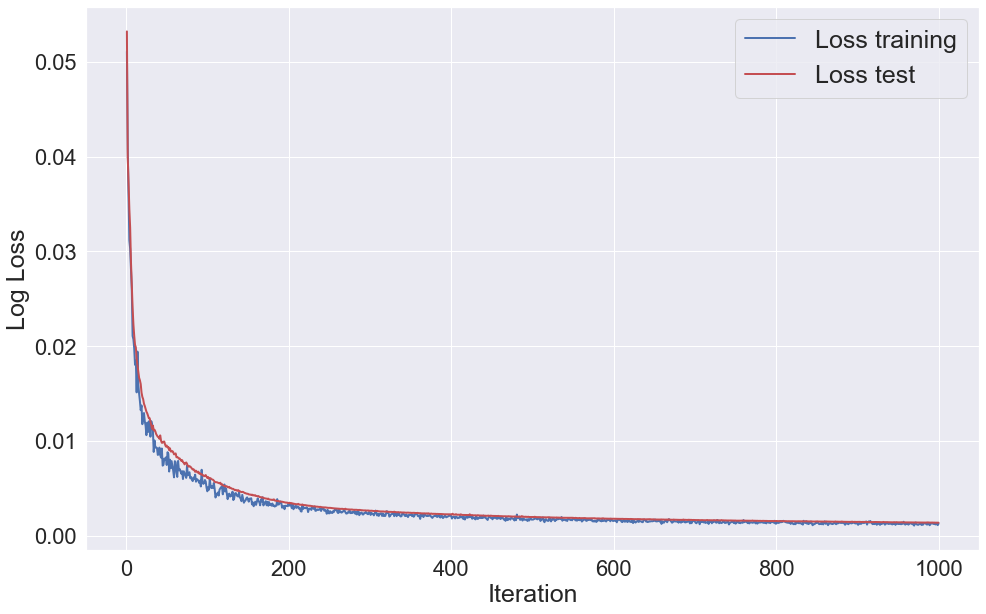

In [21]:
sns.set(font_scale=2)
plt.figure(figsize=([16,10]))
axis = np.arange(len(cost_train))+1
plt.plot(axis, cost_train, 'b', label='Loss training', linewidth=2)
plt.plot(axis, cost_test, 'r', label='Loss test', linewidth=2)
plt.legend(fontsize=25)
plt.ylabel('Log Loss',fontsize=25)
plt.xlabel('Iteration',fontsize=25)
plt.show()

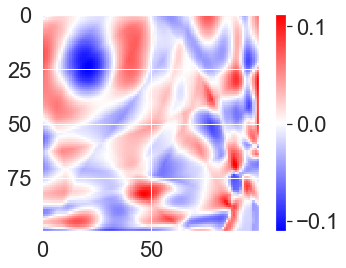

0.9845438593351717


In [22]:
pred = neural_net.feed_out(design, activation)

#plt.subplot(1, 2, 1)
plt.imshow(pred.reshape([n,n])- frank.reshape([n,n]), cmap='bwr')
#plt.subtitle('Predicted')
#plt.subplot(1, 2, 2)
#plt.subtitle('Franke')
#plt.imshow(frank.reshape([n,n]))
plt.colorbar()
plt.show()





print(fx.R2Score(frank.ravel(),pred.ravel()))

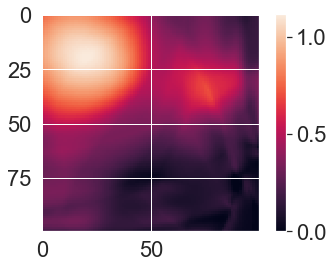

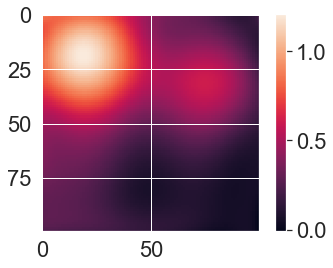

NameError: name 'yval' is not defined

In [23]:
pred = neural_net.feed_out(design, activation)



plt.imshow(pred.reshape([n,n]))
plt.colorbar()
plt.show()

beta, pred = fx.OridinaryLeastSquares(design, frank, design)



plt.imshow(pred.reshape([n,n]))
plt.colorbar()
plt.show()

fx.R2Score(yval,xval@beta)



0.9883943208697513
0.9757113345184922
0.9704380909796627
0.9293344160452393
0.80894687711973
0.5044100185251212
-0.005269624501290426
0.9948616261750548
0.9939726112090008
0.9819664930689785
0.9309726060948544
0.7904310447650696
0.5258615082062392
-0.002229556401229127


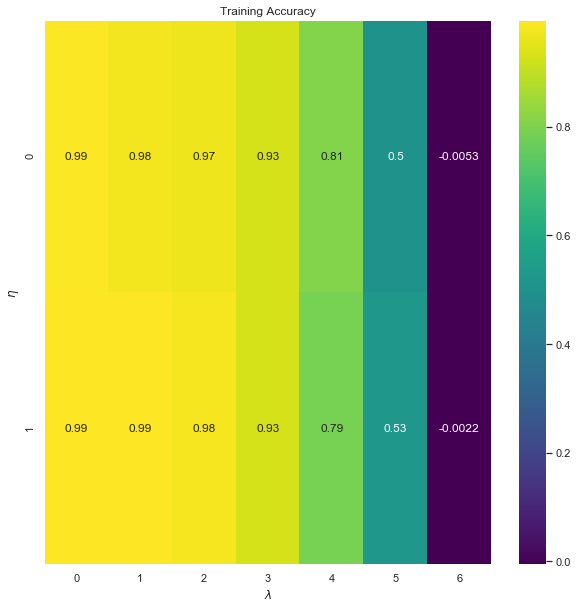

In [46]:
design=fx.DesignDesign(x,y,8)
design=np.delete(design, [0,1], axis=1)

X_train = design
Y_train = frank.ravel()

n_hidden_neurons = (50,20)
epochs = 1000
eta_vals = np.logspace(-2, -1, 2)
lmbd_vals = np.logspace(-5, 1, 7)
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
sns.set()
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(X_train, Y_train)
        DNN_scikit[i][j] = dnn
        train_accuracy[i][j] = dnn.score(X_train, Y_train)
        print(train_accuracy[i][j])
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

In [11]:
eta_vals = np.logspace(-2, -1, 2)
lmbd_vals = np.logspace(-5, 1, 7)


etamax=eta_vals[1]
lmbmax=lmbd_vals[0]

dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbmax, learning_rate_init=etamax, max_iter=epochs*100)
dnn.fit(X_train, Y_train)
DNN_scikit = dnn
train_accuracy = dnn.score(X_train, Y_train)
print(train_accuracy)

NameError: name 'n_hidden_neurons' is not defined

In [5]:
pred = dnn.predict(X_train)


plt.imshow(pred.reshape([n,n]))
plt.colorbar()
plt.show()

print(fx.R2Score(pred,frank.ravel()))

NameError: name 'dnn' is not defined